In [73]:
#partes deste notebook foram adaptadas de: "https://keras.io/examples/graph/gnn_citations/"
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
from datetime import datetime
import time
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')
print("Executing eagerly:",tf.executing_eagerly())
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab?",IN_COLAB)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Num GPUs Available:  1
Executing eagerly: True
In Colab? True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)
np.random.RandomState(seed)
tf.compat.v1.set_random_seed(seed)

In [75]:
#preencher nome da rede geodesica analisada (abaixo os nomes das redes A, B, C, D, E e F, respectivamente)
#alias opcoes = {'gemael147','ghi355gps','nive20obs','gnssrbc21','ghiniv255','kleincorr'}
alias='gemael147'
aux_filename_36_train="_0-2outs_3-6s_50000itr_train"
aux_filename_69_train="_0-2outs_6-9s_50000itr_train"
aux_filename_36="_0out200000_1-2outs_3-6s_50000itr"
aux_filename_69="_0out200000_1-2outs_6-9s_50000itr"
aux_filename_915="_0-2outs_9-15s_10000itr"
aux_filename_36_3out="_0-3outs_3-6s_10000itr"
aux_filename_69_3out="_0-3outs_6-9s_10000itr"

In [76]:
caminho="C:/Users/Patricia/Desktop/IP3new/00.treino_rna/"+alias+"_"
if IN_COLAB:
    caminho="/content/drive/MyDrive/IP3new/00.treino_rna/"+alias+"_"
A = np.loadtxt(caminho+"A")
m = A.shape[0]
A = np.concatenate((np.zeros((m,1)),A),axis=1)
n = A.shape[1]
for i in np.arange(m):
    if np.sum(A[i,:]) != 0:
        A[i,0] = -np.sum(A[i,:])

In [77]:
#importa arquivos para treino e validação do metaclassificador
caminho="C:/Users/Patricia/Desktop/IP3new/00.treino_rna/"+alias+"_"
if IN_COLAB:
    caminho="/content/drive/MyDrive/IP3new/00.treino_rna/"+alias+"_"
m = A.shape[0]
qtt_exs = m*150000

wAllEL1_pi_sigma_v_36_train = np.loadtxt(caminho+"wAllEL1_pi_sigma_v"+aux_filename_36_train).reshape(qtt_exs,1)
ypredEL1_pi_sigma_v_36_train = np.loadtxt(caminho+"ypredEL1_pi_sigma_v"+aux_filename_36_train).reshape(qtt_exs,1)
wAllELInf_pp_sig_obs_36_train = np.loadtxt(caminho+"wAllELInf_pp_sig_obs"+aux_filename_36_train).reshape(qtt_exs,1)
ypredELInf_pp_sig_obs_36_train = np.loadtxt(caminho+"ypredELInf_pp_sig_obs"+aux_filename_36_train).reshape(qtt_exs,1)
wAllELInf_pi_sig_obs_36_train = np.loadtxt(caminho+"wAllELInf_pi_sig_obs"+aux_filename_36_train).reshape(qtt_exs,1)
ypredELInf_pi_sig_obs_36_train = np.loadtxt(caminho+"ypredELInf_pi_sig_obs"+aux_filename_36_train).reshape(qtt_exs,1)
wAllIDS_pp_36_train = np.loadtxt(caminho+"wAllIDS_pp"+aux_filename_36_train).reshape(qtt_exs,1)
ypredIDS_pp_36_train = np.loadtxt(caminho+"ypredIDS_pp"+aux_filename_36_train).reshape(qtt_exs,1)
wAllSLRTMO_pp_36_train = np.loadtxt(caminho+"wAllSLRTMO_pp"+aux_filename_36_train).reshape(qtt_exs,1)
ypredSLRTMO_pp_36_train = np.loadtxt(caminho+"ypredSLRTMO_pp"+aux_filename_36_train).reshape(qtt_exs,1)
outs_positions_36_train = np.loadtxt(caminho+"outs_positions"+aux_filename_36_train).reshape(qtt_exs,1)

wAllEL1_pi_sigma_v_69_train = np.loadtxt(caminho+"wAllEL1_pi_sigma_v"+aux_filename_69_train).reshape(qtt_exs,1)
ypredEL1_pi_sigma_v_69_train = np.loadtxt(caminho+"ypredEL1_pi_sigma_v"+aux_filename_69_train).reshape(qtt_exs,1)
wAllELInf_pp_sig_obs_69_train = np.loadtxt(caminho+"wAllELInf_pp_sig_obs"+aux_filename_69_train).reshape(qtt_exs,1)
ypredELInf_pp_sig_obs_69_train = np.loadtxt(caminho+"ypredELInf_pp_sig_obs"+aux_filename_69_train).reshape(qtt_exs,1)
wAllELInf_pi_sig_obs_69_train = np.loadtxt(caminho+"wAllELInf_pi_sig_obs"+aux_filename_69_train).reshape(qtt_exs,1)
ypredELInf_pi_sig_obs_69_train = np.loadtxt(caminho+"ypredELInf_pi_sig_obs"+aux_filename_69_train).reshape(qtt_exs,1)
wAllIDS_pp_69_train = np.loadtxt(caminho+"wAllIDS_pp"+aux_filename_69_train).reshape(qtt_exs,1)
ypredIDS_pp_69_train = np.loadtxt(caminho+"ypredIDS_pp"+aux_filename_69_train).reshape(qtt_exs,1)
wAllSLRTMO_pp_69_train = np.loadtxt(caminho+"wAllSLRTMO_pp"+aux_filename_69_train).reshape(qtt_exs,1)
ypredSLRTMO_pp_69_train = np.loadtxt(caminho+"ypredSLRTMO_pp"+aux_filename_69_train).reshape(qtt_exs,1)
outs_positions_69_train = np.loadtxt(caminho+"outs_positions"+aux_filename_69_train).reshape(qtt_exs,1)

diag_redund_train = np.loadtxt(caminho+"diag_da_matriz_redund")
diag_redund_train = (np.ones((int(qtt_exs/m),diag_redund_train.shape[0]))*diag_redund_train).reshape(qtt_exs,1)

In [78]:
#importa arquivos para matriz Ev
caminho="C:/Users/Patricia/Desktop/IP3new/"+alias+"_"
if IN_COLAB:
    caminho="/content/drive/MyDrive/IP3new/"+alias+"_"
qtt_exs = m*300000

wAllEL1_pi_sigma_v_36 = np.loadtxt(caminho+"wAllEL1_pi_sigma_v"+aux_filename_36).reshape(qtt_exs,1)
ypredEL1_pi_sigma_v_36 = np.loadtxt(caminho+"ypredEL1_pi_sigma_v"+aux_filename_36).reshape(qtt_exs,1)
wAllELInf_pp_sig_obs_36 = np.loadtxt(caminho+"wAllELInf_pp_sig_obs"+aux_filename_36).reshape(qtt_exs,1)
ypredELInf_pp_sig_obs_36 = np.loadtxt(caminho+"ypredELInf_pp_sig_obs"+aux_filename_36).reshape(qtt_exs,1)
wAllELInf_pi_sig_obs_36 = np.loadtxt(caminho+"wAllELInf_pi_sig_obs"+aux_filename_36).reshape(qtt_exs,1)
ypredELInf_pi_sig_obs_36 = np.loadtxt(caminho+"ypredELInf_pi_sig_obs"+aux_filename_36).reshape(qtt_exs,1)
wAllIDS_pp_36 = np.loadtxt(caminho+"wAllIDS_pp"+aux_filename_36).reshape(qtt_exs,1)
ypredIDS_pp_36 = np.loadtxt(caminho+"ypredIDS_pp"+aux_filename_36).reshape(qtt_exs,1)
wAllSLRTMO_pp_36 = np.loadtxt(caminho+"wAllSLRTMO_pp"+aux_filename_36).reshape(qtt_exs,1)
ypredSLRTMO_pp_36 = np.loadtxt(caminho+"ypredSLRTMO_pp"+aux_filename_36).reshape(qtt_exs,1)
outs_positions_36 = np.loadtxt(caminho+"outs_positions"+aux_filename_36).reshape(qtt_exs,1)

diag_redund = np.loadtxt(caminho+"diag_da_matriz_redund")
diag_redund = (np.ones((int(qtt_exs/m),diag_redund.shape[0]))*diag_redund).reshape(qtt_exs,1)

In [79]:
#cria grafo aresta-dual a partir de A (matriz de observaçoes/arestas originais)
#arestas de G sao vertices em G'
#há aresta em G' se havia vertice comum em G
#percorre linhas de A, descendo nas colunas se elemento !=0 para capturar arestas com vertice comum em G (arestas em G')
#e salva as arestas encontradas
list_edges = []
for i in np.arange(m-1):
    for j in np.arange(n):
        if A[i,j] !=0:
            for k in np.arange(i+1,m):
                if A[k,j] !=0:
                    list_edges = np.concatenate((list_edges,np.array([i, k]))) #entram sempre 2 na lista
list_edges = np.resize(list_edges,(int(list_edges.shape[0]/2),2)) #logo aqui eh divisivel por 2
print(list_edges.shape)
#cria arestas agora no sentido contrario para grafo ser bidirecional
list_edges_aux = np.zeros(list_edges.shape)
list_edges_aux[:,0] = list_edges[:,1]
list_edges_aux[:,1] = list_edges[:,0]
list_edges = np.concatenate((list_edges,list_edges_aux))
print(list_edges.shape)

(31, 2)
(62, 2)


In [80]:
#forma conjuntos de treino, validacao e Ev
qtd_graphs = 25000 ############  IMP: 25000
#qtd de MC cenários de redes geodésicas para cada qtd de outliers e intervalo de magnitude para o treinamento
#a qtd de exemplos de treinamento vai ser isso x5xm, pois entra 0, 1 e 2 outs (sendo 1 e 2 outs para 3-6 e 6-9sigma);

#######train
aux36_train = (ypredIDS_pp_36_train,wAllIDS_pp_36_train,
             ypredEL1_pi_sigma_v_36_train,wAllEL1_pi_sigma_v_36_train,
             ypredELInf_pi_sig_obs_36_train,wAllELInf_pi_sig_obs_36_train,ypredELInf_pp_sig_obs_36_train,wAllELInf_pp_sig_obs_36_train,
             ypredSLRTMO_pp_36_train,wAllSLRTMO_pp_36_train,
              diag_redund_train)
obs_36_train = np.concatenate(aux36_train,axis=1)
label_36_train = outs_positions_36_train

aux69_train = (ypredIDS_pp_69_train,wAllIDS_pp_69_train,
             ypredEL1_pi_sigma_v_69_train,wAllEL1_pi_sigma_v_69_train,
             ypredELInf_pi_sig_obs_69_train,wAllELInf_pi_sig_obs_69_train,ypredELInf_pp_sig_obs_69_train,wAllELInf_pp_sig_obs_69_train,
             ypredSLRTMO_pp_69_train,wAllSLRTMO_pp_69_train,
              diag_redund_train)
obs_69_train = np.concatenate(aux69_train,axis=1)
label_69_train = outs_positions_69_train

#####Ev
aux36 = (ypredIDS_pp_36,wAllIDS_pp_36,
             ypredEL1_pi_sigma_v_36,wAllEL1_pi_sigma_v_36,
             ypredELInf_pi_sig_obs_36,wAllELInf_pi_sig_obs_36,ypredELInf_pp_sig_obs_36,wAllELInf_pp_sig_obs_36,
             ypredSLRTMO_pp_36,wAllSLRTMO_pp_36,
             diag_redund)
X_test36 = np.concatenate(aux36,axis=1)
y_test36 = outs_positions_36

aux = int(y_test36.shape[0]/m)
y_Ev = np.reshape(y_test36, (aux, m), order='C')
X_Ev = np.reshape(X_test36, (aux, 11*m), order='C')
aux=sum(np.transpose(y_Ev))==0        ##### era y_test (usando o "local" da fç..)
X_Ev = X_Ev[aux,:]
y_Ev = y_Ev[aux,:]
aux = int(X_Ev.shape[0]*m)
X_Ev = np.reshape(X_Ev, (aux, 11), order='C')


X_train36 = np.concatenate((obs_36_train[0:0+m*qtd_graphs,:],obs_36_train[m*50000:m*50000+m*qtd_graphs,:],
                         obs_36_train[m*100000:m*100000+int(m*qtd_graphs),:]),axis=0)
y_train36 = np.concatenate((label_36_train[0:0+m*qtd_graphs,:], label_36_train[m*50000:m*50000+m*qtd_graphs,:],
                         label_36_train[m*100000:m*100000+int(m*qtd_graphs),:]),axis=0)
X_train69 = np.concatenate((obs_69_train[m*50000:m*50000+m*qtd_graphs,:],
                         obs_69_train[m*100000:m*100000+int(m*qtd_graphs),:]),axis=0)
y_train69 = np.concatenate((label_69_train[m*50000:m*50000+m*qtd_graphs,:],
                         label_69_train[m*100000:m*100000+int(m*qtd_graphs),:]),axis=0)

X_val36 = np.concatenate((obs_36_train[m*25000:m*50000,:],obs_36_train[m*75000:m*100000,:],obs_36_train[m*125000:m*150000,:]),axis=0)
X_val69 = np.concatenate((obs_69_train[m*25000:m*50000,:],obs_69_train[m*75000:m*100000,:],obs_69_train[m*125000:m*150000,:]),axis=0)
y_val36 = np.concatenate((label_36_train[m*25000:m*50000,:],label_36_train[m*75000:m*100000,:],label_36_train[m*125000:m*150000,:]),axis=0)
y_val69 = np.concatenate((label_69_train[m*25000:m*50000,:],label_69_train[m*75000:m*100000,:],label_69_train[m*125000:m*150000,:]),axis=0)

VS = 0.8  ###### parte para treino
X_train = np.concatenate((X_train36[0:int(m*qtd_graphs*VS),:],
                          X_train36[int(m*qtd_graphs*1):int(m*qtd_graphs*(1+VS)),:],
                          X_train36[int(m*qtd_graphs*2):int(m*qtd_graphs*(2+VS)),:],
                          X_train69[0:int(m*qtd_graphs*VS),:],
                          X_train69[int(m*qtd_graphs*1):int(m*qtd_graphs*(1+VS)),:],
                          X_train36[int(m*qtd_graphs*VS):int(m*qtd_graphs*1),:],
                          X_train36[int(m*qtd_graphs*(1+VS)):int(m*qtd_graphs*2),:],
                          X_train36[int(m*qtd_graphs*(2+VS)):int(m*qtd_graphs*3),:],
                          X_train69[int(m*qtd_graphs*VS):int(m*qtd_graphs*1),:],
                          X_train69[int(m*qtd_graphs*(1+VS)):int(m*qtd_graphs*2),:]),axis=0)
y_train = np.concatenate((y_train36[0:int(m*qtd_graphs*VS),:],
                          y_train36[int(m*qtd_graphs*1):int(m*qtd_graphs*(1+VS)),:],
                          y_train36[int(m*qtd_graphs*2):int(m*qtd_graphs*(2+VS)),:],
                          y_train69[0:int(m*qtd_graphs*VS),:],
                          y_train69[int(m*qtd_graphs*1):int(m*qtd_graphs*(1+VS)),:],
                          y_train36[int(m*qtd_graphs*VS):int(m*qtd_graphs*1),:],
                          y_train36[int(m*qtd_graphs*(1+VS)):int(m*qtd_graphs*2),:],
                          y_train36[int(m*qtd_graphs*(2+VS)):int(m*qtd_graphs*3),:],
                          y_train69[int(m*qtd_graphs*VS):int(m*qtd_graphs*1),:],
                          y_train69[int(m*qtd_graphs*(1+VS)):int(m*qtd_graphs*2),:]),axis=0)

scaler_train = MinMaxScaler()
X_train = scaler_train.fit_transform(X_train)
X_val36 = scaler_train.transform(X_val36)
X_val69 = scaler_train.transform(X_val69)
X_Ev = scaler_train.transform(X_Ev)

X_val = np.concatenate((X_val36, X_val69),axis=0)
y_val = np.concatenate((y_val36, y_val69),axis=0).flatten('C')

print(X_train.shape,y_train.shape)
del (aux36_train,obs_36_train,label_36_train,aux69_train,obs_69_train,label_69_train,
     X_train36,X_train69,X_val36, X_val69, aux36, X_test36, y_test36)

(2000000, 11) (2000000, 1)


In [81]:
if 0:
    del (ypredIDS_pp_36_train,wAllIDS_pp_36_train,
     ypredEL1_pi_sigma_v_36_train,wAllEL1_pi_sigma_v_36_train,
     ypredELInf_pi_sig_obs_36_train,wAllELInf_pi_sig_obs_36_train,ypredELInf_pp_sig_obs_36_train,wAllELInf_pp_sig_obs_36_train,
     ypredSLRTMO_pp_36_train,wAllSLRTMO_pp_36_train,
     diag_redund_train)
    del (ypredIDS_pp_69_train,wAllIDS_pp_69_train,
     ypredEL1_pi_sigma_v_69_train,wAllEL1_pi_sigma_v_69_train,
     ypredELInf_pi_sig_obs_69_train,wAllELInf_pi_sig_obs_69_train,ypredELInf_pp_sig_obs_69_train,wAllELInf_pp_sig_obs_69_train,
     ypredSLRTMO_pp_69_train,wAllSLRTMO_pp_69_train)
    del (ypredIDS_pp_36,wAllIDS_pp_36,
     ypredEL1_pi_sigma_v_36,wAllEL1_pi_sigma_v_36,
     ypredELInf_pi_sig_obs_36,wAllELInf_pi_sig_obs_36,ypredELInf_pp_sig_obs_36,wAllELInf_pp_sig_obs_36,
     ypredSLRTMO_pp_36,wAllSLRTMO_pp_36)

In [82]:
qtd_grafos = int(y_train.shape[0]/m) + 150000 + 200000

list_edges_equals = np.vstack([list_edges.astype(int)]*qtd_grafos)

aux = np.arange(qtd_grafos)
aux = np.resize(aux,(list_edges.shape[0],qtd_grafos)).reshape((qtd_grafos*list_edges.shape[0],1),order='F')

list_edges_MC = list_edges_equals + m*aux
del (list_edges_equals)
print(list_edges_MC.shape)
print(list_edges_MC.T[:,0:62])
print(qtd_grafos*list_edges.shape[0],list_edges.shape[0])
imp = 0

(29450000, 2)
[[ 0  0  0  0  1  1  2  2  3  3  3  4  5  5  6  6  6  7  8  8  9  9  9 10
  11 11 12 12 12 13 14  1  4  1  2  4  2  3  5  5  4  7  7  6  8  8  7 10
  10  9 11 11 10 13 13 12 14 14 13 15 15 15]
 [ 1  4  1  2  4  2  3  5  5  4  7  7  6  8  8  7 10 10  9 11 11 10 13 13
  12 14 14 13 15 15 15  0  0  0  0  1  1  2  2  3  3  3  4  5  5  6  6  6
   7  8  8  9  9  9 10 11 11 12 12 12 13 14]]
29450000 62


In [83]:
############################################## GRAPH
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges_train = list_edges_MC[0:-(150000+200000)*list_edges.shape[0]].T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges_train.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = X_train

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges_train, edge_weights)

print("Edges shape:", edges_train.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 7750000)
Nodes shape: (2000000, 11)


In [84]:
hidden_units = [8]
learning_rate = 0.001
dropout_rate = 0.5
num_epochs = 100
batch_size = int(X_train.shape[0]/200) #int(X_train.shape[0]/50)
print(batch_size)

10000


In [85]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=10, min_delta=0.0001, restore_best_weights=True)
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=1-VS,
        callbacks=[early_stopping],shuffle=False
    )

    return history

In [86]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    #ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    #ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [87]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu,kernel_initializer=initializer,bias_initializer='zeros'))

    return keras.Sequential(fnn_layers, name=name)

In [88]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.5,
        aggregation_type="mean",
        combination_type="concat",
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        #print(node_repesentations.shape)
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [89]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        hidden_units,
        aggregation_type="mean",
        combination_type="concat",
        dropout_rate=0.5,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn([8], dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer([8], dropout_rate, aggregation_type, combination_type, normalize, name="graph_conv1")
        # Create the second GraphConv layer.
        #self.conv2 = GraphConvLayer([8], dropout_rate, aggregation_type, combination_type, normalize, name="graph_conv2")
        # Create a postprocess layer.
        self.postprocess = create_ffn([4], dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=1, name="logits", activation='sigmoid') #num_classes

    def call(self, input_node_indices): ######################### tirar camadas para acelerar?? preprocess e postprocess?
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        #x = self.node_features
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        #x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        #x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [90]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 11]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[0.5       ]
 [0.50015754]
 [0.5       ]], shape=(3, 1), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2000000, 8)              140       
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 304       
 )                                                               
                                                                 
 postprocess (Sequential)    (2000000, 4)              68        
                                                                 
 logits (Dense)              multiple                  5         
                                                                 
Total params: 517
Trainable params: 431
Non-trainable params: 86
_________________________________________________________________


In [91]:
start = datetime.now()
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)
np.random.RandomState(seed)
tf.compat.v1.set_random_seed(seed)

ids_train = np.arange(X_train.shape[0])
history = run_experiment(gnn_model, ids_train, y_train.astype(np.uint8))
end = datetime.now()
gnn_model.reset_states()
print(f"Time taken in (hh:mm:ss.ms) is {end - start}")

Epoch 1/100
160/160 [==============================] - 48s 135ms/step - loss: 0.4589 - acc: 0.9493 - val_loss: 0.2884 - val_acc: 0.9250
Epoch 2/100
160/160 [==============================] - 6s 38ms/step - loss: 0.2081 - acc: 0.9521 - val_loss: 0.2026 - val_acc: 0.9529
Epoch 3/100
160/160 [==============================] - 6s 38ms/step - loss: 0.1505 - acc: 0.9536 - val_loss: 0.1556 - val_acc: 0.9540
Epoch 4/100
160/160 [==============================] - 6s 38ms/step - loss: 0.1441 - acc: 0.9544 - val_loss: 0.1463 - val_acc: 0.9539
Epoch 5/100
160/160 [==============================] - 6s 38ms/step - loss: 0.1433 - acc: 0.9546 - val_loss: 0.1463 - val_acc: 0.9544
Epoch 6/100
160/160 [==============================] - 6s 38ms/step - loss: 0.1440 - acc: 0.9546 - val_loss: 0.1444 - val_acc: 0.9549
Epoch 7/100
160/160 [==============================] - 6s 38ms/step - loss: 0.1435 - acc: 0.9547 - val_loss: 0.1440 - val_acc: 0.9548
Epoch 8/100
160/160 [==============================] - 6s 38

In [92]:
print(gnn_model(np.arange(0,5)))

tf.Tensor(
[[0.00712002]
 [0.00339796]
 [0.09862292]
 [0.06100578]
 [0.10737719]], shape=(5, 1), dtype=float32)


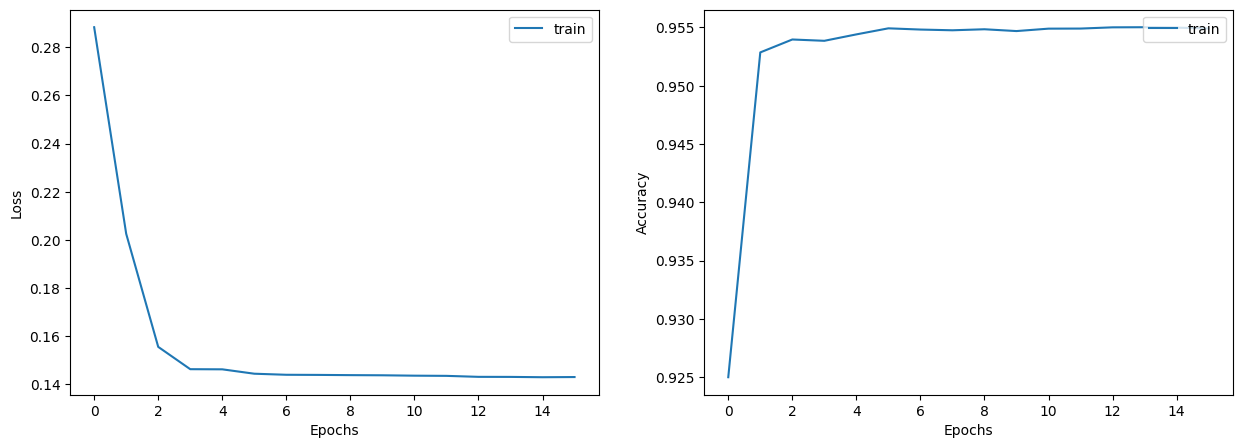

In [93]:
display_learning_curves(history)

In [94]:
def clf_eval(y_pred, y_val):
  acc = 100*accuracy_score(y_pred, y_val)
  print('Acc Rede: {}'.format(acc))
  acc_obs = 100*accuracy_score(y_pred.flatten(), y_val.flatten())
  print('Acc Obs: {}'.format(acc_obs))
  #acurácia somente para conjunto que tenha 2 outliers
  aux=sum(np.transpose(y_val))==2
  acc2=100*accuracy_score(y_val[aux,:], y_pred[aux,:])
  print('Accuracy 2 out: {}'.format(acc2))
  #acurácia somente para conjunto que tenha 1 outliers
  aux=sum(np.transpose(y_val))==1
  acc1=100*accuracy_score(y_val[aux,:], y_pred[aux,:])
  print('Accuracy 1 out: {}'.format(acc1))
  #acurácia somente para conjunto que tenha 0 outliers
  aux=sum(np.transpose(y_val))==0
  acc0=100*accuracy_score(y_val[aux,:], y_pred[aux,:])
  print('Accuracy 0 out: {}'.format(acc0))
  acc = [acc, acc1, acc2]
  return acc

In [95]:
def fp_control(FP, probs, y_test):

  aux = y_Ev.shape[0]
  probsEv = np.reshape(probs_Ev, (aux, m), order='C')
  maxs = np.sort(np.amax(probsEv, axis=1))
  position = int((1-FP)*maxs.shape[0])
  threshold = maxs[position]
  print(threshold, np.count_nonzero(maxs == threshold), maxs.shape)
  aux = int(y_test.shape[0]/m)
  probs = np.reshape(probs, (aux, m), order='C')

  preds = (np.where(probs[:] > threshold, 1, 0))
  del (probs,maxs)
  print("--com VC|FP=5%")
  acc =clf_eval(preds.reshape(int(y_test.shape[0]/m),m),y_test.reshape(int(y_test.shape[0]/m),m))
  return acc

In [96]:
#### PREDICOES COM CJ TRAIN
probs_all1 = gnn_model(ids_train)
probs_train_36 = np.concatenate((probs_all1[0:int(3*m*qtd_graphs*VS),:],
                                 probs_all1[int(5*m*qtd_graphs*VS):int(5*m*qtd_graphs*VS+3*m*qtd_graphs*(1-VS)),:]
                                 ),axis=0)
probs_train_69 = np.concatenate((probs_all1[int(3*m*qtd_graphs*VS):int(5*m*qtd_graphs*VS),:],
                                 probs_all1[int(5*m*qtd_graphs*VS+3*m*qtd_graphs*(1-VS)):int(5*m*qtd_graphs*VS+5*m*qtd_graphs*(1-VS)),:]
                                 ),axis=0)
y_train_36 = np.concatenate((y_train[0:int(3*m*qtd_graphs*VS),:],
                          y_train[int(5*m*qtd_graphs*VS):int(5*m*qtd_graphs*VS+3*m*qtd_graphs*(1-VS)),:],
                          ),axis=0)
y_train_69 = np.concatenate((y_train[int(3*m*qtd_graphs*VS):int(5*m*qtd_graphs*VS),:],
                          y_train[int(5*m*qtd_graphs*VS+3*m*qtd_graphs*(1-VS)):int(5*m*qtd_graphs*VS+5*m*qtd_graphs*(1-VS)),:],
                          ),axis=0)

In [97]:
#### PREDICOES COM CJ VAL
gnn_model.node_features = X_val
gnn_model.edges = list_edges_MC[0:150000*list_edges.shape[0]].T
gnn_model.edge_weights = tf.ones(shape=gnn_model.edges.shape[1])
graph_info = (gnn_model.node_features, gnn_model.edges, gnn_model.edge_weights)
ids_val = np.arange(X_val.shape[0])
probs_all = gnn_model(ids_val)
probs_val_36 = probs_all[0:int(X_val.shape[0]/2),:]
probs_val_69 = probs_all[int(X_val.shape[0]/2):int(X_val.shape[0]),:]

In [98]:
#### PREDICOES COM CJ Ev
gnn_model.node_features = X_Ev
gnn_model.edges = list_edges_MC[0:200000*list_edges.shape[0]].T
gnn_model.edge_weights = tf.ones(shape=gnn_model.edges.shape[1])
graph_info = (gnn_model.node_features, gnn_model.edges, gnn_model.edge_weights)
ids_Ev = np.arange(X_Ev.shape[0])
probs_Ev = gnn_model(ids_Ev)

In [99]:
print("-----Cj Train 3-6s:")
acc36 = fp_control(0.05, probs_train_36, y_train_36)
print("-----Cj Train 6-9s:")
acc69 = fp_control(0.05, probs_train_69, y_train_69)
print("__MSR__36_69_5%__Train:", (acc36[1] + acc36[2] + acc69[1] + acc69[2])/4)
print(learning_rate)
print("---------xxxxxx----------")
print("-----Cj Validacao 3-6s:")
acc36 = fp_control(0.05, probs_val_36, y_val36)
print("-----Cj Validacao 6-9s:")
acc69 = fp_control(0.05, probs_val_69, y_val69)
print("__MSR__36_69_5%__Validacao:", (acc36[1] + acc36[2] + acc69[1] + acc69[2])/4)
print(learning_rate)

-----Cj Train 3-6s:
0.5283968 1 (200000,)
--com VC|FP=5%
Acc Rede: 47.13466666666667
Acc Obs: 95.23183333333334
Accuracy 2 out: 10.96
Accuracy 1 out: 32.604
Accuracy 0 out: 97.84
-----Cj Train 6-9s:
0.5283968 1 (200000,)
--com VC|FP=5%
Acc Rede: 59.648
Acc Obs: 95.799875
Accuracy 2 out: 46.204
Accuracy 1 out: 73.092
Accuracy 0 out: nan
__MSR__36_69_5%__Train: 40.715
0.001
---------xxxxxx----------
-----Cj Validacao 3-6s:
0.5283968 1 (200000,)
--com VC|FP=5%
Acc Rede: 46.51466666666666


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Acc Obs: 95.139
Accuracy 2 out: 10.100000000000001
Accuracy 1 out: 34.68
Accuracy 0 out: 94.76400000000001
-----Cj Validacao 6-9s:
0.5283968 1 (200000,)
--com VC|FP=5%
Acc Rede: 71.29466666666666
Acc Obs: 97.0945
Accuracy 2 out: 44.788
Accuracy 1 out: 74.332
Accuracy 0 out: 94.76400000000001
__MSR__36_69_5%__Validacao: 40.974999999999994
0.001
